In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_task import CPC
from libs.ssl_data import SSLHBNDataModule
%load_ext autoreload
%autoreload 2

In [5]:
import wandb
run = wandb.init(project="eeg-ssl", job_type="training")

wandb: Currently logged in as: dt-young112 (sccn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [2]:
import os
model = "3k5y24ev"
artifact_dir = f'artifacts/model-{model}'
num_version = 11 if model == "0cu5slnx" else 31
for version in range(num_version):
    if os.path.exists(f'{artifact_dir}:v{version}'):
        print(f"Artifact directory {artifact_dir}:v{version} already exists. Skipping download.")
        continue
    else:
        artifact = run.use_artifact(f'sccn/eeg-ssl/model-{model}:v{version}', type='model')
        artifact_dir = artifact.download()

Artifact directory artifacts/model-3k5y24ev:v0 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v1 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v2 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v3 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v4 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v5 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v6 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v7 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v8 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v9 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v10 already exists. Skipping download.
Artifact directory artifacts/model-3k5y24ev:v11 already exists. Skipping download.
Artifact direc

In [3]:
# load config from runs/config_CPC.yaml
import yaml
import lightning as L
with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)

ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['window_len_s'] = 20
config['data']['num_workers'] = 2

if model == "0cu5slnx":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRContextualizer'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None}
elif model == "3k5y24ev":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRLSTM'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512}

config['trainer']['callbacks'] = None
config['trainer']['logger'] = None

trainer = L.Trainer(**config['trainer'])
cpc_model = CPC.CPCLit(downsampling_factor=96, **config['model']['init_args'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
from collections import defaultdict
import json
mode = 'test'
if os.path.exists(f'model-{model}_scores-{mode}.json'):
    version_scores = json.load(open(f'model-{model}_scores.json'))
else:
    attributes = ['age', 'p_factor']
    version_scores = defaultdict(list)
    for attr in attributes:
        config['data']['target_label'] = attr
        print('Loading data module...')
        litDataModule = SSLHBNDataModule(**config['data'])
        litDataModule.setup(stage=mode)

        artifact_dir = f'artifacts/model-{model}'
        num_version = 11 if model == "0cu5slnx" else 31
        for version in range(num_version):
            artifact_path = f'{artifact_dir}:v{version}/model.ckpt'
            print(f'Loading model from {artifact_path}...')
            scores = trainer.test(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)
            version_scores[attr].append(scores)

    with open(f'model-{model}_scores-{mode}.json', 'w') as f:
        json.dump(version_scores, f)


Loading data module...
Loading model from artifacts/model-3k5y24ev:v0/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v0/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v0/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.35599822143690896              │
│               val_Regressor/R2                │              0.0163177711118363               │
│           val_Regressor/concordance           │              0.03593284093466325              │
│               val_Regressor/mae               │              3.1956985073718664               │
│               val_Regressor/mse               │              14.742429030275442               │
│         val_Regressor/subject_iqr_iqr         │              0.28724992275238037              │
│        val_Regressor/subject_iqr_mean         │              0.6124417185783386               │
│       val_Regressor/subject_iqr_median        │              0.5597726106643677               │
│         val_Regressor/subject_iqr_std         │              0.21147479116916656              │
│         val_Regressor/subject_std_iqr         │              0.1292703002691269               │
│        val_Regressor/subject_std_mean         │              0.49153679609298706              │
│       val_Regressor/subject_std_median        │              0.4860832691192627               │
│         val_Regressor/subject_std_std         │              0.13866767287254333              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3463819817158704               │
│      val_Regressor/subject_with_mean_R2       │             0.032508508830744964              │
│  val_Regressor/subject_with_mean_concordance  │              0.03610872587552038              │
│      val_Regressor/subject_with_mean_mae      │              3.1105294819279647               │
│      val_Regressor/subject_with_mean_mse      │              13.834190506447369               │
│    val_Regressor/subject_with_median_NRMSE    │              0.34771221384541473              │
│     val_Regressor/subject_with_median_R2      │              0.02506320517775329              │
│ val_Regressor/subject_with_median_concordance │              0.02925815887473049              │
│     val_Regressor/subject_with_median_mae     │              3.1269370950029685               │
│     val_Regressor/subject_with_median_mse     │               13.94065113173861               │
│                val_loss_epoch                 │              0.03504680469632149              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v1/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v1/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v1/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3576521918270152               │
│               val_Regressor/R2                │             0.007156148018054087              │
│           val_Regressor/concordance           │              0.03197758457155394              │
│               val_Regressor/mae               │               3.200655047372236               │
│               val_Regressor/mse               │              14.879734121590223               │
│         val_Regressor/subject_iqr_iqr         │              0.27438023686408997              │
│        val_Regressor/subject_iqr_mean         │              0.6910269260406494               │
│       val_Regressor/subject_iqr_median        │              0.6621837615966797               │
│         val_Regressor/subject_iqr_std         │              0.2096266746520996               │
│         val_Regressor/subject_std_iqr         │              0.14948078989982605              │
│        val_Regressor/subject_std_mean         │               0.551798939704895               │
│       val_Regressor/subject_std_median        │               0.538686215877533               │
│         val_Regressor/subject_std_std         │              0.12680883705615997              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3472883800895413               │
│      val_Regressor/subject_with_mean_R2       │             0.027438498717442528              │
│  val_Regressor/subject_with_mean_concordance  │              0.03214230328295074              │
│      val_Regressor/subject_with_mean_mae      │              3.1174160749116124               │
│      val_Regressor/subject_with_mean_mse      │               13.90668673656126               │
│    val_Regressor/subject_with_median_NRMSE    │              0.34850244670247715              │
│     val_Regressor/subject_with_median_R2      │             0.020626763092156164              │
│ val_Regressor/subject_with_median_concordance │             0.025927831733110845              │
│     val_Regressor/subject_with_median_mae     │              3.1228472430315866               │
│     val_Regressor/subject_with_median_mse     │              14.004087953191993               │
│                val_loss_epoch                 │              0.00789710134267807              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v2/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v2/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v2/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.35740970668597566              │
│               val_Regressor/R2                │             0.008501970992400576              │
│           val_Regressor/concordance           │             0.042164041294209975              │
│               val_Regressor/mae               │               3.175626552222244               │
│               val_Regressor/mse               │              14.859564295294751               │
│         val_Regressor/subject_iqr_iqr         │              0.2493864744901657               │
│        val_Regressor/subject_iqr_mean         │              0.7248105406761169               │
│       val_Regressor/subject_iqr_median        │               0.682108461856842               │
│         val_Regressor/subject_iqr_std         │              0.32476022839546204              │
│         val_Regressor/subject_std_iqr         │              0.19242629408836365              │
│        val_Regressor/subject_std_mean         │              0.6077951788902283               │
│       val_Regressor/subject_std_median        │              0.5409395694732666               │
│         val_Regressor/subject_std_std         │              0.21544773876667023              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3455684667513849               │
│      val_Regressor/subject_with_mean_R2       │             0.037047685751771864              │
│  val_Regressor/subject_with_mean_concordance  │              0.04450785111159446              │
│      val_Regressor/subject_with_mean_mae      │              3.0815493578769155               │
│      val_Regressor/subject_with_mean_mse      │              13.769284676431164               │
│    val_Regressor/subject_with_median_NRMSE    │               0.347079674971699               │
│     val_Regressor/subject_with_median_R2      │             0.028607081277361335              │
│ val_Regressor/subject_with_median_concordance │             0.035737793212818676              │
│     val_Regressor/subject_with_median_mae     │               3.10522036053794                │
│     val_Regressor/subject_with_median_mse     │              13.889977138695041               │
│                val_loss_epoch                 │             0.004296422470360994              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v3/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v3/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v3/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3565016807006001               │
│               val_Regressor/R2                │              0.01353352056012691              │
│           val_Regressor/concordance           │             0.040191940422077035              │
│               val_Regressor/mae               │              3.1883766634551436               │
│               val_Regressor/mse               │              14.784156546495263               │
│         val_Regressor/subject_iqr_iqr         │              0.2459002286195755               │
│        val_Regressor/subject_iqr_mean         │              0.6455152630805969               │
│       val_Regressor/subject_iqr_median        │              0.6132871508598328               │
│         val_Regressor/subject_iqr_std         │              0.26621538400650024              │
│         val_Regressor/subject_std_iqr         │              0.15597864985466003              │
│        val_Regressor/subject_std_mean         │              0.5498286485671997               │
│       val_Regressor/subject_std_median        │              0.48968276381492615              │
│         val_Regressor/subject_std_std         │              0.2000867873430252               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3458345032048772               │
│      val_Regressor/subject_with_mean_R2       │             0.035564454185925354              │
│  val_Regressor/subject_with_mean_concordance  │             0.040367618042488354              │
│      val_Regressor/subject_with_mean_mae      │               3.095367284245257               │
│      val_Regressor/subject_with_mean_mse      │              13.790493450083838               │
│    val_Regressor/subject_with_median_NRMSE    │              0.34819177795992845              │
│     val_Regressor/subject_with_median_R2      │             0.022372088210745433              │
│ val_Regressor/subject_with_median_concordance │              0.02638410518059681              │
│     val_Regressor/subject_with_median_mae     │               3.117965405864179               │
│     val_Regressor/subject_with_median_mse     │               13.9791314957899                │
│                val_loss_epoch                 │             0.005141068249940872              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v4/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v4/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v4/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3549940173686622               │
│               val_Regressor/R2                │             0.021859509315505843              │
│           val_Regressor/concordance           │              0.04892902691439617              │
│               val_Regressor/mae               │               3.178633422417257               │
│               val_Regressor/mse               │               14.6593750929645                │
│         val_Regressor/subject_iqr_iqr         │              0.3014642000198364               │
│        val_Regressor/subject_iqr_mean         │              0.7485020160675049               │
│       val_Regressor/subject_iqr_median        │              0.7416715621948242               │
│         val_Regressor/subject_iqr_std         │              0.2214808315038681               │
│         val_Regressor/subject_std_iqr         │              0.1315385401248932               │
│        val_Regressor/subject_std_mean         │              0.5694742798805237               │
│       val_Regressor/subject_std_median        │              0.5517802238464355               │
│         val_Regressor/subject_std_std         │              0.1300908923149109               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3445957561470569               │
│      val_Regressor/subject_with_mean_R2       │              0.04246111745381198              │
│  val_Regressor/subject_with_mean_concordance  │             0.048359893737886676              │
│      val_Regressor/subject_with_mean_mae      │              3.0881976974202705               │
│      val_Regressor/subject_with_mean_mse      │              13.691877850486724               │
│    val_Regressor/subject_with_median_NRMSE    │              0.3454683075544016               │
│     val_Regressor/subject_with_median_R2      │              0.03760580700725036              │
│ val_Regressor/subject_with_median_concordance │              0.04420269715212023              │
│     val_Regressor/subject_with_median_mae     │               3.096787758139453               │
│     val_Regressor/subject_with_median_mse     │              13.761304083480773               │
│                val_loss_epoch                 │             0.0038220579735934734             │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v5/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v5/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v5/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.35697465895530434              │
│               val_Regressor/R2                │              0.01091425266929913              │
│           val_Regressor/concordance           │              0.04907842553967645              │
│               val_Regressor/mae               │               3.190852375193776               │
│               val_Regressor/mse               │              14.823411470349537               │
│         val_Regressor/subject_iqr_iqr         │              0.30793872475624084              │
│        val_Regressor/subject_iqr_mean         │              0.9128612279891968               │
│       val_Regressor/subject_iqr_median        │               0.871960461139679               │
│         val_Regressor/subject_iqr_std         │               0.269711971282959               │
│         val_Regressor/subject_std_iqr         │              0.20214545726776123              │
│        val_Regressor/subject_std_mean         │              0.6869246363639832               │
│       val_Regressor/subject_std_median        │              0.6668659448623657               │
│         val_Regressor/subject_std_std         │              0.14338132739067078              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3447137398049294               │
│      val_Regressor/subject_with_mean_R2       │             0.041805315528983145              │
│  val_Regressor/subject_with_mean_concordance  │              0.04947137613163709              │
│      val_Regressor/subject_with_mean_mae      │               3.094459853473427               │
│      val_Regressor/subject_with_mean_mse      │              13.701255182324147               │
│    val_Regressor/subject_with_median_NRMSE    │              0.3458302297595584               │
│     val_Regressor/subject_with_median_R2      │              0.03558828892228649              │
│ val_Regressor/subject_with_median_concordance │              0.04421832828446011              │
│     val_Regressor/subject_with_median_mae     │              3.1126704490473274               │
│     val_Regressor/subject_with_median_mse     │              13.790152636457567               │
│                val_loss_epoch                 │             0.0034747819881886244             │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v6/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v6/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v6/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3572245303184188               │
│               val_Regressor/R2                │             0.009529108405306186              │
│           val_Regressor/concordance           │              0.04522458327045801              │
│               val_Regressor/mae               │              3.1886233937027746               │
│               val_Regressor/mse               │              14.844170604152016               │
│         val_Regressor/subject_iqr_iqr         │              0.37709057331085205              │
│        val_Regressor/subject_iqr_mean         │              0.8448780179023743               │
│       val_Regressor/subject_iqr_median        │              0.8322427272796631               │
│         val_Regressor/subject_iqr_std         │              0.2690316140651703               │
│         val_Regressor/subject_std_iqr         │              0.19250468909740448              │
│        val_Regressor/subject_std_mean         │              0.6635162234306335               │
│       val_Regressor/subject_std_median        │              0.6518614888191223               │
│         val_Regressor/subject_std_std         │              0.16208873689174652              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3454364204348542               │
│      val_Regressor/subject_with_mean_R2       │              0.03778345897557844              │
│  val_Regressor/subject_with_mean_concordance  │             0.044406746272944844              │
│      val_Regressor/subject_with_mean_mae      │               3.094998922421591               │
│      val_Regressor/subject_with_mean_mse      │              13.758763832536834               │
│    val_Regressor/subject_with_median_NRMSE    │              0.34641404772305356              │
│     val_Regressor/subject_with_median_R2      │              0.0323293711923347               │
│ val_Regressor/subject_with_median_concordance │             0.040389566584074076              │
│     val_Regressor/subject_with_median_mae     │               3.107550823521848               │
│     val_Regressor/subject_with_median_mse     │               13.83675200103338               │
│                val_loss_epoch                 │             0.0026544551365077496             │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v7/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v7/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v7/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3571089695506462               │
│               val_Regressor/R2                │             0.010169831834739629              │
│           val_Regressor/concordance           │              0.06538472759386978              │
│               val_Regressor/mae               │              3.1794869755582202               │
│               val_Regressor/mse               │              14.834568092884597               │
│         val_Regressor/subject_iqr_iqr         │              0.3573724925518036               │
│        val_Regressor/subject_iqr_mean         │              1.0624858140945435               │
│       val_Regressor/subject_iqr_median        │               1.009055495262146               │
│         val_Regressor/subject_iqr_std         │              0.33444544672966003              │
│         val_Regressor/subject_std_iqr         │              0.2279895693063736               │
│        val_Regressor/subject_std_mean         │              0.8513782620429993               │
│       val_Regressor/subject_std_median        │              0.8263620138168335               │
│         val_Regressor/subject_std_std         │              0.17756380140781403              │
│     val_Regressor/subject_with_mean_NRMSE     │              0.3419412404421363               │
│      val_Regressor/subject_with_mean_R2       │               0.057156666411323               │
│  val_Regressor/subject_with_mean_concordance  │              0.0657076607631231               │
│      val_Regressor/subject_with_mean_mae      │               3.068047290568195               │
│      val_Regressor/subject_with_mean_mse      │              13.481745745211738               │
│    val_Regressor/subject_with_median_NRMSE    │              0.33915770592660044              │
│     val_Regressor/subject_with_median_R2      │              0.07244440994454038              │
│ val_Regressor/subject_with_median_concordance │              0.0822747748593635               │
│     val_Regressor/subject_with_median_mae     │              3.0415028485707456               │
│     val_Regressor/subject_with_median_mse     │              13.263145831535352               │
│                val_loss_epoch                 │              0.00371575471945107              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v8/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v8/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v8/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              val_Regressor/NRMSE              │              0.3593956408271617               │
│               val_Regressor/R2                │            -0.0025470868638350908             │
│           val_Regressor/concordance           │              0.04763131517883764              │
│               val_Regressor/mae               │               3.182075226272943               │
│               val_Regressor/mse               │              15.025156339669765               │
│         val_Regressor/subject_iqr_iqr         │              0.42174115777015686              │
│        val_Regressor/subject_iqr_mean         │              0.9784265756607056               │
│       val_Regressor/subject_iqr_median        │              0.9116687774658203               │
│         val_Regressor/subject_iqr_std         │              0.34789812564849854              │
│         val_Regressor/subject_std_iqr         │              0.25442594289779663              │
│        val_Regressor/subject_std_mean         │              0.7943403124809265               │
│       val_Regressor/subject_std_median        │              0.7864989638328552               │
│         val_Regressor/subject_std_std         │              0.1860811412334442               │
│     val_Regressor/subject_with_mean_NRMSE     │              0.34454483348876186              │
│      val_Regressor/subject_with_mean_R2       │             0.042744097273864745              │
│  val_Regressor/subject_with_mean_concordance  │             0.051529723898581466              │
│      val_Regressor/subject_with_mean_mae      │              3.0751608603659557               │
│      val_Regressor/subject_with_mean_mse      │               13.68783151336043               │
│    val_Regressor/subject_with_median_NRMSE    │              0.34577623903780874              │
│     val_Regressor/subject_with_median_R2      │             0.035889391690976824              │
│ val_Regressor/subject_with_median_concordance │              0.04598871681786587              │
│     val_Regressor/subject_with_median_mae     │               3.085718811108105               │
│     val_Regressor/subject_with_median_mse     │              13.785847158732853               │
│                val_loss_epoch                 │              0.00179860123898834              │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

Loading model from artifacts/model-3k5y24ev:v9/model.ckpt...
Using datasets: ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005509', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
Validation release: ds005505
Test release: ds005510


Restoring states from the checkpoint path at artifacts/model-3k5y24ev:v9/model.ckpt
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at artifacts/model-3k5y24ev:v9/model.ckpt


test sampler None


Testing: |          | 0/? [00:00<?, ?it/s]

test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step
test_step


In [ ]:
metrics = [f'{mode}_Regressor/mae', f'{mode}_Regressor/subject_with_mean_mae']

/tmp/ipykernel_1622145/1628101466.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(models))


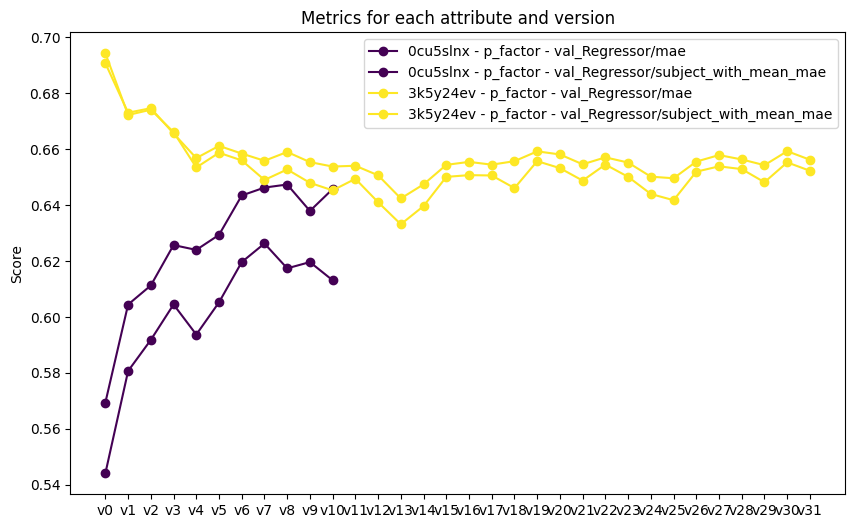

In [ ]:
# plot the metrics for each attribute for each version from scores
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def plot_metrics(scores, metrics, attributes, models):
    # create a color map
    cmap = cm.get_cmap('viridis', len(models))
    colors = [cmap(i) for i in range(len(models))]

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # loop through each attribute and plot the metrics
    for i, model in enumerate(models):
        scores = json.load(open(f'model-{model}_scores-{mode}.json'))
        for attr in attributes:
            for metric in metrics:
                # extract the scores for the current attribute and metric
                scores_attr = [s[0][metric] for s in scores[attr]]
                # plot the scores with a line and marker
                ax.plot(range(len(scores_attr)), scores_attr, label=f'{model} - {attr} - {metric}', color=colors[i], marker='o')

    # set the x-axis ticks and labels
    ax.set_xticks(range(len(scores_attr)))
    ax.set_xticklabels([f'v{v}' for v in range(len(scores_attr))])

    # set the y-axis label
    ax.set_ylabel('Score')

    # set the title
    ax.set_title('Metrics for each attribute and version')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()
attributes = ['p_factor']
plot_metrics(version_scores, metrics, attributes, ['0cu5slnx', '3k5y24ev'])

In [8]:
# load output.png
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('output.png')

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fc057bb5ea0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fbf48fa6d40, raw_cell="# load output.png
import matplotlib.pyplot as plt
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B100.83.226.64/home/dung/eeg-ssl/notebooks/CPC_evaluation.ipynb#X10sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

FileNotFoundError: [Errno 2] No such file or directory: 'output.png'

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fc057bb5ea0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fbf48fa6ad0, execution_count=8 error_before_exec=None error_in_exec=[Errno 2] No such file or directory: 'output.png' info=<ExecutionInfo object at 7fbf48fa6d40, raw_cell="# load output.png
import matplotlib.pyplot as plt
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B100.83.226.64/home/dung/eeg-ssl/notebooks/CPC_evaluation.ipynb#X10sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe